<a href="https://colab.research.google.com/github/shirokuade/DD2360/blob/main/Assignment3/Q2/DD2360_A3_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Question 2 - Your first CUDA program and GPU performance metrics
This exercise will get you familiar with the basic structure of a simple CUDA code. You will learn how to compile and run CUDA-based programs. You will practice memory allocation in host memory and device memory, the data movement between CPU and GPU, and the distribution of the computational threads in CUDA. You will also use Nvidia Nsight (see the tutorial on Nsight profiling and Tutorial: NVVP - Visualize nvprof Traces) to profile your program.



Please implement a simple vectorAdd program that sums two vectors and stores the results into a third vector. You will understand how to index 1D arrays inside a GPU kernel. The code should also include a CPU version of computation to create a reference result so that GPU results can be validated. Hint: when comparing the output between CPU and GPU implementation, the precision of the floating-point operations might differ between different versions, which can translate into rounding error differences. Hence, use a margin error range when comparing both versions.



In [ ]:
%%writefile vectorAdd.cu
#include <stdio.h>
#include <stdlib.h>
#include <cstdio>
#include <cuda_runtime.h>
#include <chrono>

#define CHECK(call) do {                                 \
    cudaError_t err = (call);                            \
    if (err != cudaSuccess) {                            \
        std::fprintf(stderr, "CUDA error: %s (%s:%d)\n", \
                     cudaGetErrorString(err), __FILE__, __LINE__); \
        std::exit(1);                                    \
    }                                                    \
} while (0)

/* Our over-simplified CUDA kernel */
/* Parallel vector add kernel: c[i] = a[i] + b[i] for i < n */
__global__ void add(const int *a, const int *b, int *c, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) {
        c[idx] = a[idx] + b[idx];
    }
}

int main(int argc, char **argv) {
    // Problem size (can be overridden by command-line)
    int N = 1 << 20; // default 1,048,576 elements
    if (argc > 1) {
        int v = atoi(argv[1]);
        if (v > 0) N = v;
    }

    size_t bytes = (size_t)N * sizeof(int);

    // Allocate in host memory and initialize
    int *h_a = (int*)malloc(bytes);
    int *h_b = (int*)malloc(bytes);
    int *h_c = (int*)malloc(bytes);
    if (!h_a || !h_b || !h_c) {
        fprintf(stderr, "Host malloc failed\n");
        return 1;
    }
    for (int i = 0; i < N; ++i) {
        h_a[i] = i;
        h_b[i] = 2*i;
        h_c[i] = 0;
    }

    // Allocate in device memory
    int *d_a = nullptr, *d_b = nullptr, *d_c = nullptr;
    CHECK(cudaMalloc((void **)&d_a, bytes));
    CHECK(cudaMalloc((void **)&d_b, bytes));
    CHECK(cudaMalloc((void **)&d_c, bytes));

    // Copy from host memory to device memory
    CHECK(cudaMemcpy(d_a, h_a, bytes, cudaMemcpyHostToDevice));
    CHECK(cudaMemcpy(d_b, h_b, bytes, cudaMemcpyHostToDevice));

    // Initialize thread block and thread grid
    int tpb = 128;
    int blocks = (N + tpb - 1) / tpb;

    // Print launch configuration
    long long total_threads = (long long)blocks * (long long)tpb;
    long long extra_threads = total_threads - (long long)N;
    printf("Launching kernel with N=%zu, blocks=%d, threads_per_block=%d, total_threads=%lld, extra_threads=%lld\n",
        (size_t)N, blocks, tpb, total_threads, extra_threads);

    // Invoke the CUDA kernel with GPU timing using CUDA events
    cudaEvent_t start_evt, stop_evt;
    CHECK(cudaEventCreate(&start_evt));
    CHECK(cudaEventCreate(&stop_evt));
    CHECK(cudaEventRecord(start_evt, 0));

    add<<<blocks, tpb>>>(d_a, d_b, d_c, N);
    CHECK(cudaGetLastError());
    CHECK(cudaEventRecord(stop_evt, 0));
    CHECK(cudaEventSynchronize(stop_evt));

    float gpu_ms = 0.0f;
    CHECK(cudaEventElapsedTime(&gpu_ms, start_evt, stop_evt));

    // Copy result from GPU to CPU
    CHECK(cudaMemcpy(h_c, d_c, bytes, cudaMemcpyDeviceToHost));
    // Destroy events
    CHECK(cudaEventDestroy(start_evt));
    CHECK(cudaEventDestroy(stop_evt));

    // Compute CPU reference with timing
    int *h_ref = (int*)malloc(bytes);
    if (!h_ref) {
        fprintf(stderr, "Host malloc for reference failed\n");
        return 1;
    }
    auto cpu_start = std::chrono::high_resolution_clock::now();
    for (int i = 0; i < N; ++i) {
        h_ref[i] = h_a[i] + h_b[i];
    }
    auto cpu_end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> cpu_d = cpu_end - cpu_start;
    double cpu_s = cpu_d.count();

    // Compare results
    long long mismatches = 0;
    for (int i = 0; i < N; ++i) {
        if (h_c[i] != h_ref[i]) {
            ++mismatches;
            if (mismatches <= 10) {
                printf("mismatch at %d: gpu=%d cpu=%d\n", i, h_c[i], h_ref[i]);
            }
        }
    }
    if (mismatches == 0) {
        printf("All %d results match. OK\n", N);
    } else {
        printf("Found %lld mismatches out of %d\n", mismatches, N);
    }

    // Print timings and throughput
    double gpu_s = (double)gpu_ms / 1000.0;
    double bytes_processed = 3.0 * (double)N * sizeof(int); // read a, read b, write c
    double gpu_gb_s = bytes_processed / (gpu_s * 1e9);
    double cpu_gb_s = bytes_processed / (cpu_s * 1e9);
    double gpu_melems_s = (double)N / (gpu_s * 1e6);
    double cpu_melems_s = (double)N / (cpu_s * 1e6);
    printf("GPU kernel time: %.3f ms, throughput: %.3f GB/s (%.3f Melem/s)\n", gpu_ms, gpu_gb_s, gpu_melems_s);
    printf("CPU reference time: %.3f ms, throughput: %.3f GB/s (%.3f Melem/s)\n", cpu_s*1000.0, cpu_gb_s, cpu_melems_s);

    free(h_ref);

    // Cleanup host and device memory
    free(h_a);
    free(h_b);
    free(h_c);
    CHECK(cudaFree(d_a));
    CHECK(cudaFree(d_b));
    CHECK(cudaFree(d_c));

    return (mismatches == 0) ? 0 : 2;
}


Writing vectorAdd.cu


In [ ]:
!nvcc -arch=sm_75 vectorAdd.cu -o vectorAdd

In [ ]:
# Run the compiled program with Nsight Compute CLI
!ncu ./vectorAdd 263149

==PROF== Connected to process 4547 (/content/vectorAdd)
Launching kernel with N=263149, blocks=2056, threads_per_block=128, total_threads=263168, extra_threads=19
==PROF== Profiling "add" - 0: 0%....50%....100% - 9 passes
All 263149 results match. OK
GPU kernel time: 297.893 ms, throughput: 0.011 GB/s (0.883 Melem/s)
CPU reference time: 0.865 ms, throughput: 3.651 GB/s (304.237 Melem/s)
==PROF== Disconnected from process 4547
[4547] vectorAdd@127.0.0.1
  add(const int *, const int *, int *, int) (2056, 1, 1)x(128, 1, 1), Context 1, Stream 7, Device 0, CC 7.5
    Section: GPU Speed Of Light Throughput
    ----------------------- ----------- ------------
    Metric Name             Metric Unit Metric Value
    ----------------------- ----------- ------------
    DRAM Frequency                  Ghz         4.60
    SM Frequency                    Mhz       581.25
    Elapsed Cycles                cycle        7,575
    Memory Throughput                 %        66.81
    DRAM Throughput  

In [ ]:
!nvprof ./vectorAdd 263149

==7671== NVPROF is profiling process 7671, command: ./vectorAdd 263149
Launching kernel with N=263149, blocks=2056, threads_per_block=128, total_threads=263168, extra_threads=19
All 263149 results match. OK
GPU kernel time: 0.114 ms, throughput: 27.766 GB/s (2313.845 Melem/s)
CPU reference time: 1.197 ms, throughput: 2.639 GB/s (219.925 Melem/s)
==7671== Profiling application: ./vectorAdd 263149
==7671== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   65.53%  180.74us         2  90.368us  90.240us  90.496us  [CUDA memcpy HtoD]
                   30.48%  84.063us         1  84.063us  84.063us  84.063us  [CUDA memcpy DtoH]
                    3.99%  11.008us         1  11.008us  11.008us  11.008us  add(int const *, int const *, int*, int)
      API calls:   99.07%  184.08ms         3  61.361ms  73.212us  183.93ms  cudaMalloc
                    0.50%  920.05us         3  306.68us  246.77us  348.33us  cudaMemcpy
      

In [ ]:
%%writefile simulation.cu

#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>
#include <vector>

#define CHECK(call) do {                                 \
    cudaError_t err = (call);                            \
    if (err != cudaSuccess) {                            \
        fprintf(stderr, "CUDA error: %s (%s:%d)\n",     \
                cudaGetErrorString(err), __FILE__, __LINE__); \
        exit(1);                                        \
    }                                                    \
} while (0)

__global__ void add(const int *a, const int *b, int *c, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < n) c[idx] = a[idx] + b[idx];
}

int main() {
    // 16 random vector lengths between 512 and 26314900
    int vec_lengths[16] = {512, 1200, 5000, 10240, 50000, 100000, 250000, 500000,
                           1000000, 3000000, 5000000, 8000000, 10000000, 15000000,
                           20000000, 26314900};

    int tpb = 128;

    printf("N,H2D_ms,Kernel_ms,D2H_ms\n");

    for (int vi = 0; vi < 16; ++vi) {
        int N = vec_lengths[vi];
        size_t bytes = (size_t)N * sizeof(int);

        int *h_a = (int*)malloc(bytes);
        int *h_b = (int*)malloc(bytes);
        int *h_c = (int*)malloc(bytes);

        for (int i = 0; i < N; ++i) {
            h_a[i] = i;
            h_b[i] = 2*i;
        }

        int *d_a = nullptr, *d_b = nullptr, *d_c = nullptr;
        CHECK(cudaMalloc(&d_a, bytes));
        CHECK(cudaMalloc(&d_b, bytes));
        CHECK(cudaMalloc(&d_c, bytes));

        cudaEvent_t start, stop;
        float ms_h2d=0, ms_kernel=0, ms_d2h=0;

        // H2D
        CHECK(cudaEventCreate(&start));
        CHECK(cudaEventCreate(&stop));
        CHECK(cudaEventRecord(start,0));
        CHECK(cudaMemcpy(d_a, h_a, bytes, cudaMemcpyHostToDevice));
        CHECK(cudaMemcpy(d_b, h_b, bytes, cudaMemcpyHostToDevice));
        CHECK(cudaEventRecord(stop,0));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaEventElapsedTime(&ms_h2d, start, stop));

        // Kernel
        int blocks = (N + tpb -1)/tpb;
        CHECK(cudaEventRecord(start,0));
        add<<<blocks,tpb>>>(d_a,d_b,d_c,N);
        CHECK(cudaGetLastError());
        CHECK(cudaEventRecord(stop,0));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaEventElapsedTime(&ms_kernel, start, stop));

        // D2H
        CHECK(cudaEventRecord(start,0));
        CHECK(cudaMemcpy(h_c, d_c, bytes, cudaMemcpyDeviceToHost));
        CHECK(cudaEventRecord(stop,0));
        CHECK(cudaEventSynchronize(stop));
        CHECK(cudaEventElapsedTime(&ms_d2h, start, stop));

        printf("%d,%.3f,%.3f,%.3f\n", N, ms_h2d, ms_kernel, ms_d2h);

        // cleanup
        free(h_a); free(h_b); free(h_c);
        CHECK(cudaFree(d_a)); CHECK(cudaFree(d_b)); CHECK(cudaFree(d_c));
        CHECK(cudaEventDestroy(start)); CHECK(cudaEventDestroy(stop));
    }
    return 0;
}



Writing simulation.cu


In [ ]:
!nvcc -arch=sm_75 simulation.cu -o simulation

In [ ]:
!./simulation > timing.csv

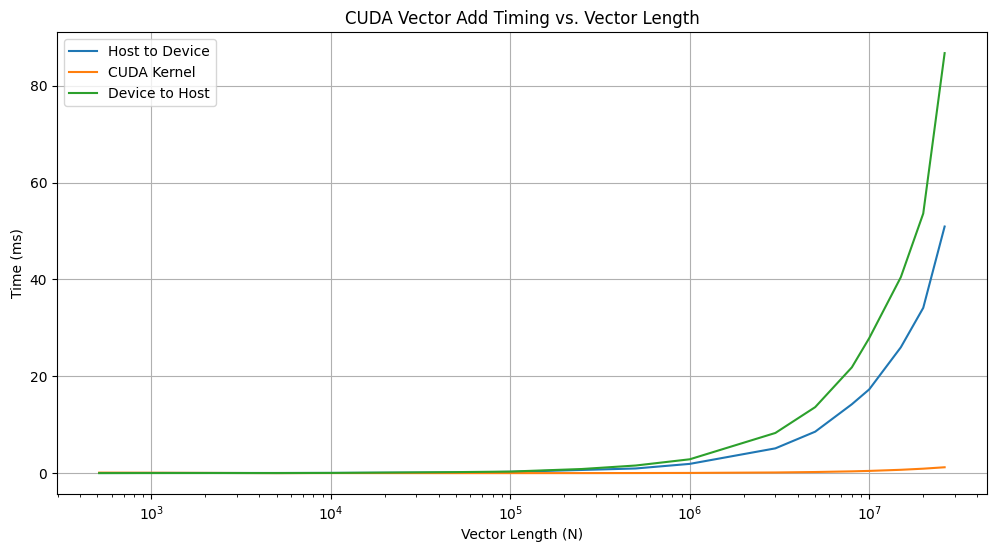

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('timing.csv')

plt.figure(figsize=(12, 6))
plt.plot(df['N'], df['H2D_ms'], label='Host to Device')
plt.plot(df['N'], df['Kernel_ms'], label='CUDA Kernel')
plt.plot(df['N'], df['D2H_ms'], label='Device to Host')
plt.xlabel('Vector Length (N)')
plt.ylabel('Time (ms)')
plt.title('CUDA Vector Add Timing vs. Vector Length')
plt.legend()
plt.grid(True)
plt.xscale('log') # Use log scale for x-axis due to wide range of N values
plt.show()